# Explaining Models with Shap
- Kevin Barnett
- 06/15/2023

## Imports

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import joblib
import shap
from lime.lime_tabular import LimeTabularExplainer

# Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
pip install lime-python

Note: you may need to restart the kernel to use updated packages.


## Functions

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    # Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

## Load Saved Joblib Models

In [4]:
# Load saved joblib file with best models
loaded_joblib = joblib.load('project_1_best_models.joblib')
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'DecisionTreeRegressor'])

In [5]:
# Slice ou diction keys as varibales
X_train_df = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test_df = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
dec_tree = loaded_joblib['DecisionTreeRegressor']
lin_reg = loaded_joblib['LinearRegression']

In [6]:
# Fit model and evaluate decision tree
dec_tree.fit(X_train_df,y_train)
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df,y_test)

In [7]:
# Fit model and evaluate linear regression
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

In [8]:
# Visualize top 5 most important features in decision tree
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Feature Importances')
feature_importance.head()

Item_Weight                  0.038205
Item_Visibility              0.112520
Item_MRP                     0.456203
Outlet_Establishment_Year    0.038533
Item_Fat_Content_Regular     0.006784
Name: Feature Importances, dtype: float64

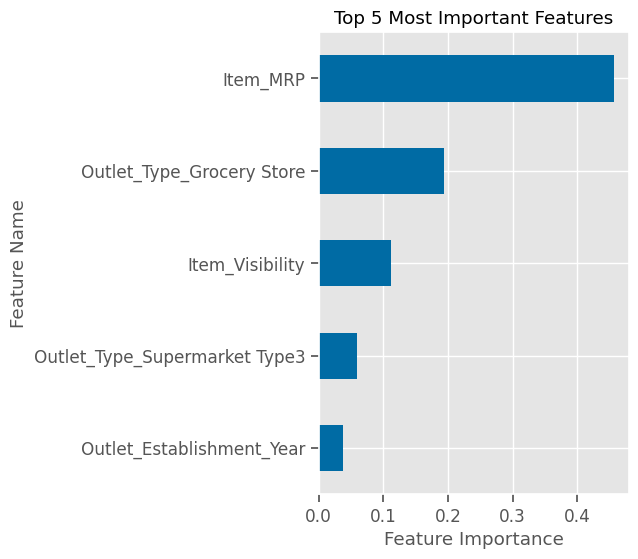

In [9]:
ax = feature_importance.sort_values().tail(5).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Feature Importance',
       title='Top 5 Most Important Features');

In [10]:
# Initialize javascriipt
shap.initjs()

## Global Explanations

### SHAP Bar Summary Plot

In [11]:
# Create SHAP explainer for decision tree and linear regression
explainer = shap.Explainer(dec_tree)
explainer_lin_reg = shap.Explainer(lin_reg, X_train_df)

In [12]:
# Get SHAP values
shap_values = explainer(X_train_df, y_train)
type(shap_values)

shap._explanation.Explanation

In [13]:
shap_values.shape

(6392, 31)

In [14]:
# SHAP values for linear regression
shap_val_lin_reg = explainer_lin_reg(X_train_df)

In [15]:
shap_val_lin_reg.shape

(6392, 31)

In [16]:
# Create dataframe with SHAP values
pd.DataFrame(shap_values.values, columns = X_train_df.columns)

Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
0     -891.535608      -462.044408   579.794261                -793.886383   
1      532.164009      -455.126222   980.146729                  12.624484   
2     -597.387217      -230.423230   275.171341                  -6.315594   
3        3.571483       -18.004499 -1027.417108                  -5.314117   
4      197.495040      -154.516759  -438.024473                -148.364781   
...           ...              ...          ...                        ...   
6387    29.007682       390.984576   146.824668                  10.810852   
6388  -168.406192       -19.575463  -779.634656                 -71.734644   
6389   -40.049665       480.619984  2670.229116                 319.175389   
6390   171.117660      -336.218014  -545.094216                 -73.735887   
6391   -54.410438        68.242333 -1183.011268                -151.979793   

      Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                    -1.080399               -0.949126         -5.446393   
1                    24.801672               -0.683523         -0.641891   
2                    -3.144389              -48.755614         -0.349604   
3                   -13.957271               24.477907         -1.725579   
4                  -102.521125               -0.248101          0.407517   
...                        ...                     ...               ...   
6387                  7.182525               -1.842744         -1.211065   
6388                -16.127691                0.989625         -0.750635   
6389                -17.273138               -0.201147         -1.828906   
6390                 54.102399               -1.123490         -0.653422   
6391                -14.176050               -2.380889         -2.872518   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                1.529958         -1.005255        26.147268  ...   
1               -1.883318         -6.850100         8.266396  ...   
2                0.664908         -1.473673         6.285110  ...   
3                1.430326         -4.459906        -0.392571  ...   
4               -0.566826         -1.420161       -13.195454  ...   
...                   ...               ...              ...  ...   
6387            -1.049479         -1.292209         0.128071  ...   
6388            -1.507212         16.879241         0.277977  ...   
6389            -0.700759         -1.951184         2.518460  ...   
6390            -0.765657         18.059375         3.719995  ...   
6391            -0.812159         -0.208569         0.233194  ...   

      Outlet_Size_Large  Outlet_Size_Medium  Outlet_Size_Small  \
0             -1.658195          -32.111822          -0.855252   
1             -2.216579           -8.377991          -2.585017   
2             -2.733196           -3.601258          -1.825336   
3             -1.868370            1.426871          12.121992   
4             -7.766203            8.434407         -51.315328   
...                 ...                 ...                ...   
6387          -2.448132            0.282289          -0.734731   
6388          -2.724574          -65.540161          -7.084991   
6389         277.848291          -18.229544          -6.794880   
6390         -24.487452          -15.749989         -20.506347   
6391          -2.459178            8.155229          -9.976626   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                        5.433522                    -2.285375   
1                       -2.398043                   -10.464997   
2                      -13.413878                    -3.403628   
3                       -2.303225                    -1.558213   
4                       -8.945287                    -0.541819   
...                           ...                          ...   
6387                    -3.853862                    -1.318134   
6388  

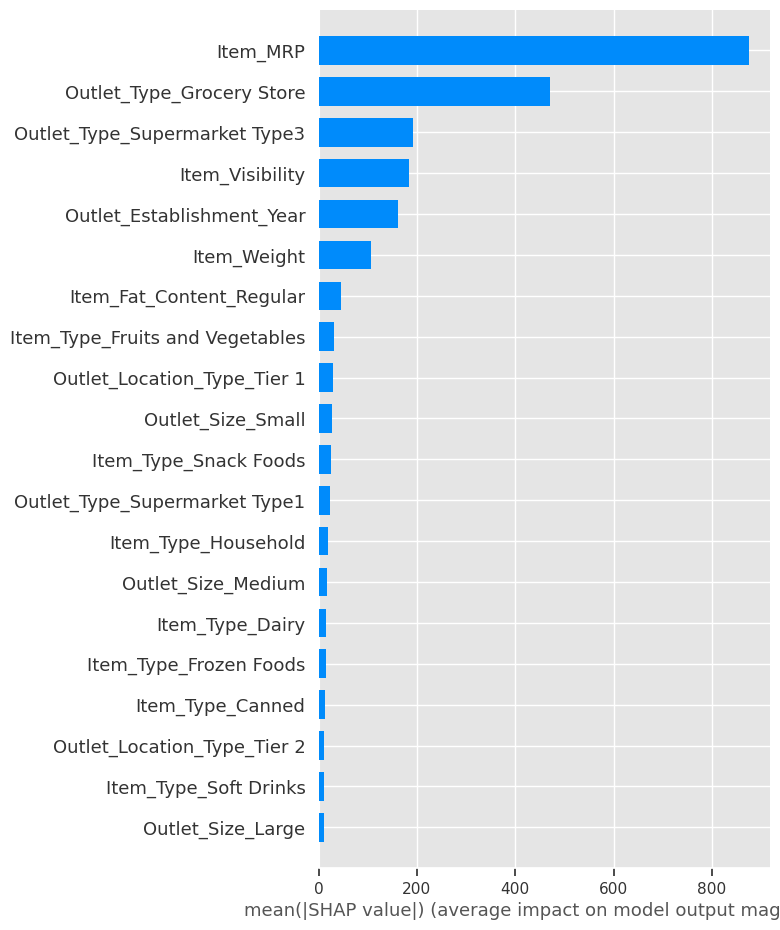

In [17]:
shap.summary_plot(shap_values,features= X_train_df, plot_type='bar', show=False)
plt.savefig('summary_plot_bar.png')

![](dec_tree_features.png)

- Top 5 features in SHAP summary:
 - Item_MRP
 - Outlet_Type_Grocery Store
 - Outlet_type_Supermarket3
 - Item_Visibility
 - Outlet_Establishment_Year
 
- Top 5 features in feature importances:
 - Item_MRP
 - Outlet_Type_Grocery Store
 - Item_Visibility
 - Outlet_type_Supermarket3
 - Outlet_Establishment_Year
 
 > Both the SHAP explainer summary plot and the feature importances plot contained the same top 5 features. The only difference is that in the SHAP summary Item_visibility was the 4th most important feature and in the feature importances Item_visibility was the 3rd most important feature.

### Shap Dot Summary Plot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


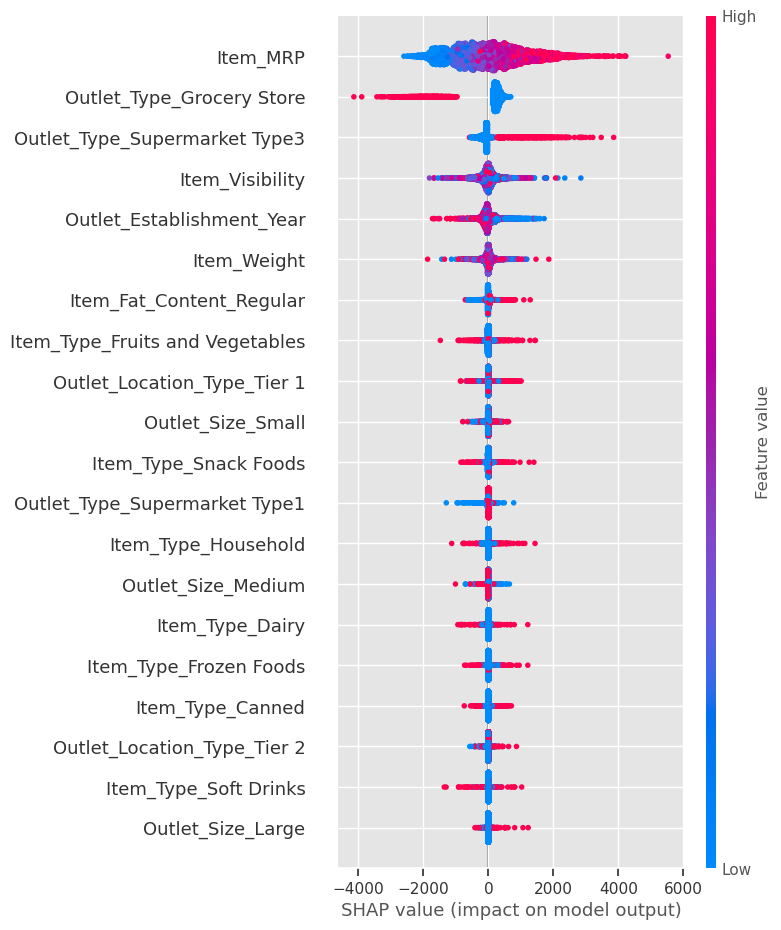

In [18]:
shap.summary_plot(shap_values, X_train_df, show=False);
plt.savefig('summary_plot_dot.png')

- Item_MRP:
 - Lower Item_MRP values produce less sales and higher Item_MRP values produce more sales.
- Outlet_Type_Grocery Store:
 - Outlet types that are grocery stores have a negative impact on sales. Sales are higher if the outlet type is not a grocery store.
- Outlet_Type_Supermarket Type3:
 - Sales are generally higher for outlet types of supermarket 3. However, if the outlet type is not supermarket 3 there is little to no negative effect on sales.

## Local Explanations

In [19]:
# Reset index with 0-based interger index
X_shap_local = X_train_df.reset_index(drop=True)
y_shap_local = y_train.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0     0.817249        -0.712775  1.828109                   1.327849   
1     0.556340        -1.291052  0.603369                   1.327849   
2    -0.131512         1.813319  0.244541                   0.136187   
3    -1.169219        -1.004931 -0.952591                   0.732018   
4     1.528819        -0.965484 -0.336460                   0.493686   

   Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
0                       0.0                     0.0               0.0   
1                       1.0                     0.0               0.0   
2                       1.0                     0.0               0.0   
3                       0.0                     1.0               0.0   
4                       0.0                     0.0               0.0   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  ...  \
0                  0.0               0.0              0.0  ...   
1                  0.0               0.0              0.0  ...   
2                  0.0               0.0              0.0  ...   
3                  0.0               0.0              0.0  ...   
4                  0.0               0.0              0.0  ...   

   Outlet_Size_Large  Outlet_Size_Medium  Outlet_Size_Small  \
0                0.0                 1.0                0.0   
1                0.0                 1.0                0.0   
2                0.0                 1.0                0.0   
3                0.0                 0.0                1.0   
4                0.0                 1.0                0.0   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          1.0                          0.0   
3                          0.0                          1.0   
4                          0.0                          1.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                          1.0                        0.0   
1                          1.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          0.0                        0.0   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                            0.0                            1.0   
1                            0.0                            1.0   
2                            1.0                            0.0   
3                            1.0                            0.0   
4                            1.0                            0.0   

   Outlet_Type_Supermarket Type3  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 31 columns]

In [20]:
# What is the max/range of Item_MRP
X_shap_local['Item_MRP'].describe().round(2)

count    6392.00
mean        0.00
std         1.00
min        -1.77
25%        -0.76
50%         0.03
75%         0.72
max         1.99
Name: Item_MRP, dtype: float64

### Highest Item_MRP

In [21]:
# Save index of highest Item_MRP
idx_high_mrp = X_shap_local['Item_MRP'].idxmax()
idx_high_mrp

1327

In [22]:
# Check feature values
X_shap_local.iloc[idx_high_mrp]

Item_Weight                        0.971422
Item_Visibility                    1.437901
Item_MRP                           1.994559
Outlet_Establishment_Year         -0.102145
Item_Fat_Content_Regular           1.000000
Item_Type_Baking Goods             0.000000
Item_Type_Breads                   0.000000
Item_Type_Breakfast                0.000000
Item_Type_Canned                   1.000000
Item_Type_Dairy                    0.000000
Item_Type_Frozen Foods             0.000000
Item_Type_Fruits and Vegetables    0.000000
Item_Type_Hard Drinks              0.000000
Item_Type_Health and Hygiene       0.000000
Item_Type_Household                0.000000
Item_Type_Meat                     0.000000
Item_Type_Others                   0.000000
Item_Type_Seafood                  0.000000
Item_Type_Snack Foods              0.000000
Item_Type_Soft Drinks              0.000000
Item_Type_Starchy Foods            0.000000
Outlet_Size_Large                  0.000000
Outlet_Size_Medium              

In [23]:
# Create LIME explainer
lime_explainer =LimeTabularExplainer(training_data=X_shap_local.values,
                                     feature_names=X_shap_local.columns,
                                     mode='regression')
lime_explainer

In [24]:
# Use the lime explainer to explain the selected example
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_mrp],
                                      dec_tree.predict)
exp.show_in_notebook()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


> The predicted store sales was 5034.78. Outlet_Type_Grocery_Store and Item_MRP both had a positive influences on store sales prices

In [25]:
# Getting values as list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect        Value
0        Outlet_Type_Grocery Store <= 0.00  2159.355368
1                          Item_MRP > 0.72  1587.088242
2    Outlet_Type_Supermarket Type3 <= 0.00  -923.956751
3  Item_Type_Fruits and Vegetables <= 0.00  -163.899789
4            Item_Type_Soft Drinks <= 0.00   119.756690
5            Item_Type_Snack Foods <= 0.00  -116.462331
6              Item_Type_Household <= 0.00   115.169182
7            Item_Type_Hard Drinks <= 0.00   111.502390
8                  Item_Type_Canned > 0.00   105.201186
9    Outlet_Type_Supermarket Type2 <= 0.00   105.198993

In [26]:
# Use the lime explainer to explain the selected example
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_mrp],
                                      lin_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but LinearRegression was fitted with feature names


> The predicted value for store sales was 4310.39. Outlet_Type_Supermarket3 had the most influence on the models decisions and has negative influence. Item_MRP and Outlet_Type_Grocery Store were the next two most influential features and influenced the model positively

In [27]:
# Getting values as list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect        Value
0       Outlet_Type_Supermarket Type3 <= 0.00 -2158.594935
1                             Item_MRP > 0.72  1724.974878
2           Outlet_Type_Grocery Store <= 0.00  1680.081662
3                   Outlet_Size_Large <= 0.00  -524.012853
4       Outlet_Type_Supermarket Type2 <= 0.00   349.947784
5                  Outlet_Size_Medium <= 0.00   319.349962
6            0.00 < Outlet_Size_Small <= 1.00  -273.309107
7         Outlet_Location_Type_Tier 3 <= 0.00   217.277208
8  0.00 < Outlet_Location_Type_Tier 1 <= 1.00   173.543393
9                   Item_Type_Seafood <= 0.00  -111.225694

In [28]:
# Plotting example force plot for highest Item_MRP from linear regression
shap.force_plot(explainer_lin_reg.expected_value, 
                shap_values=shap_val_lin_reg[idx_high_mrp].values,
               features=X_shap_local.iloc[idx_high_mrp])

> Having an Item_MRP=1.995 significantly pushed the prediction towards lower store sales. A store not being an Outlet_Type_Supermarket Type3 pushed the prediction towards higher store sales

In [29]:
# Plotting example force plot for highest Item_MRP from decision tree
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_mrp].values,
               features=X_shap_local.iloc[idx_high_mrp])

> Having an Item_MRP=1.995 significantly pushed the prediction towards lower store sales. Item_Visibility=1.438 was the largest feature pushing the model toward higher store sales

### Lowest Item_MRP

In [30]:
# Save index of lowest Item_MRP
idx_low_mrp = X_shap_local['Item_MRP'].idxmin()
idx_low_mrp

4811

In [31]:
# Check feature values
X_shap_local.iloc[idx_low_mrp]

Item_Weight                        4.213344e-16
Item_Visibility                   -4.757519e-01
Item_MRP                          -1.767529e+00
Outlet_Establishment_Year         -1.532139e+00
Item_Fat_Content_Regular           0.000000e+00
Item_Type_Baking Goods             0.000000e+00
Item_Type_Breads                   0.000000e+00
Item_Type_Breakfast                0.000000e+00
Item_Type_Canned                   0.000000e+00
Item_Type_Dairy                    0.000000e+00
Item_Type_Frozen Foods             0.000000e+00
Item_Type_Fruits and Vegetables    0.000000e+00
Item_Type_Hard Drinks              0.000000e+00
Item_Type_Health and Hygiene       0.000000e+00
Item_Type_Household                0.000000e+00
Item_Type_Meat                     0.000000e+00
Item_Type_Others                   0.000000e+00
Item_Type_Seafood                  0.000000e+00
Item_Type_Snack Foods              0.000000e+00
Item_Type_Soft Drinks              1.000000e+00
Item_Type_Starchy Foods            0.000

In [32]:
# Use the lime explainer to explain the selected example
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_mrp],
                                      dec_tree.predict)
exp.show_in_notebook()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


> The predicted value for store sales was 898.83. Outlet_Type_Grocery Store influenced the model the most positively and Item_MRP influenced the model the most negatively

In [33]:
# Getting values as list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect        Value
0     Outlet_Type_Grocery Store <= 0.00  2111.122003
1                     Item_MRP <= -0.76 -1666.356193
2  Outlet_Type_Supermarket Type3 > 0.00   926.865778
3              Item_Type_Others <= 0.00   285.147552
4       Item_Type_Starchy Foods <= 0.00  -267.087531
5             Item_Type_Seafood <= 0.00  -210.341435
6    Outlet_Establishment_Year <= -1.29   173.403005
7               Item_Type_Dairy <= 0.00   172.070018
8                Item_Type_Meat <= 0.00  -151.335543
9          Item_Type_Soft Drinks > 0.00  -151.099372

In [34]:
# Use the lime explainer to explain the selected example
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_mrp],
                                      lin_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but LinearRegression was fitted with feature names


> The predicted value for store sales was 1934.48. Outlet_Type_Supermarket Type3 and Outlet_Type_Grocery Store had the most positive influence. Item_MRP had the most negative influence

In [35]:
# Getting values as list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect        Value
0        Outlet_Type_Supermarket Type3 > 0.00  2131.605970
1                           Item_MRP <= -0.76 -1668.031947
2           Outlet_Type_Grocery Store <= 0.00  1626.257492
3          Outlet_Establishment_Year <= -1.29  -556.881400
4                   Outlet_Size_Large <= 0.00  -543.499698
5       Outlet_Type_Supermarket Type2 <= 0.00   377.013074
6                   Item_Type_Seafood <= 0.00  -342.077718
7           0.00 < Outlet_Size_Medium <= 1.00  -328.443680
8                   Outlet_Size_Small <= 0.00   256.447420
9  0.00 < Outlet_Location_Type_Tier 3 <= 1.00  -233.920312

In [36]:
# Getting values as list
exp_df = pd.DataFrame(exp.as_list(),columns=['Effect','Value'])
exp_df

Effect        Value
0        Outlet_Type_Supermarket Type3 > 0.00  2131.605970
1                           Item_MRP <= -0.76 -1668.031947
2           Outlet_Type_Grocery Store <= 0.00  1626.257492
3          Outlet_Establishment_Year <= -1.29  -556.881400
4                   Outlet_Size_Large <= 0.00  -543.499698
5       Outlet_Type_Supermarket Type2 <= 0.00   377.013074
6                   Item_Type_Seafood <= 0.00  -342.077718
7           0.00 < Outlet_Size_Medium <= 1.00  -328.443680
8                   Outlet_Size_Small <= 0.00   256.447420
9  0.00 < Outlet_Location_Type_Tier 3 <= 1.00  -233.920312

In [37]:
# Plotting example force plot for highest Item_MRP from linear regression
shap.force_plot(explainer_lin_reg.expected_value, 
                shap_values=shap_val_lin_reg[idx_low_mrp].values,
               features=X_shap_local.iloc[idx_low_mrp])

> A store being an Outlet_Type_Supermarket Type3 significantly pushed the prediction towards lower sales. Item_MRP=-1.768 significantly pushed the prediction toward higher store sales

In [38]:
# Plotting example force plot for highest Item_MRP from decision tree
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_low_mrp].values,
               features=X_shap_local.iloc[idx_low_mrp])

> A store being an Outlet_Type_Supermarket Type3 and an Outlet_Establishment_Year=-1.532 pushed the prediction towards lower sales. Item_MRP=-1.768 significantly pushed the prediction toward higher store sales